In [1]:
"""
Optuna example that optimizes a classifier configuration for Iris dataset using sklearn.
In this example, we optimize a classifier configuration for Iris dataset. Classifiers are from
scikit-learn. We optimize both the choice of classifier (among SVC and RandomForest) and their
hyperparameters.
"""

import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

[I 2022-12-24 15:31:59,155] A new study created in memory with name: no-name-cb5e7a42-1381-4f5c-91a3-79ed8617045e
[I 2022-12-24 15:32:00,267] Trial 0 finished with value: 0.32 and parameters: {'classifier': 'SVC', 'svc_c': 1.933765155648916e-06}. Best is trial 0 with value: 0.32.
[I 2022-12-24 15:32:00,589] Trial 1 finished with value: 0.9533333333333333 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 8}. Best is trial 1 with value: 0.9533333333333333.
[I 2022-12-24 15:32:00,871] Trial 2 finished with value: 0.96 and parameters: {'classifier': 'SVC', 'svc_c': 85899.87865175807}. Best is trial 2 with value: 0.96.
[I 2022-12-24 15:32:01,187] Trial 3 finished with value: 0.9666666666666667 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 3 with value: 0.9666666666666667.
[I 2022-12-24 15:32:01,469] Trial 4 finished with value: 0.32 and parameters: {'classifier': 'SVC', 'svc_c': 3.552414994467598e-07}. Best is trial 3 with value: 0.96666666666

FrozenTrial(number=71, values=[0.9866666666666667], datetime_start=datetime.datetime(2022, 12, 24, 15, 32, 7, 837266), datetime_complete=datetime.datetime(2022, 12, 24, 15, 32, 7, 850839), params={'classifier': 'SVC', 'svc_c': 4.137632136570211}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'svc_c': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=71, state=TrialState.COMPLETE, value=None)


In [2]:
"""
Optuna example that optimizes a classifier configuration for cancer dataset using LightGBM tuner.
In this example, we optimize the validation log loss of cancer detection.
"""

import numpy as np
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


if __name__ == "__main__":
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
    accuracy = accuracy_score(val_y, prediction)

    best_params = model.params
    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-24 15:33:52,851] A new study created in memory with name: no-name-92967aaf-42d9-43b9-bdb2-01050f3a65b2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000569026	valid_1's binary_logloss: 0.153632


feature_fraction, val_score: 0.129305:  14%|#4        | 1/7 [06:17<37:44, 377.46s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.00452093	valid_1's binary_logloss: 0.129305


feature_fraction, val_score: 0.129305:  29%|##8       | 2/7 [06:17<12:58, 155.68s/it]

[100]	valid_0's binary_logloss: 0.000614405	valid_1's binary_logloss: 0.141593
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.00452093	valid_1's binary_logloss: 0.129305


feature_fraction, val_score: 0.111585:  43%|####2     | 3/7 [06:18<05:39, 84.77s/it]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


feature_fraction, val_score: 0.111585:  57%|#####7    | 4/7 [06:18<02:34, 51.46s/it]

[100]	valid_0's binary_logloss: 0.000516499	valid_1's binary_logloss: 0.144907
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


feature_fraction, val_score: 0.111585:  71%|#######1  | 5/7 [06:19<01:06, 33.06s/it]

[100]	valid_0's binary_logloss: 0.000791887	valid_1's binary_logloss: 0.147474
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


feature_fraction, val_score: 0.111585:  86%|########5 | 6/7 [06:19<00:21, 21.97s/it]

[100]	valid_0's binary_logloss: 0.00051187	valid_1's binary_logloss: 0.148713
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.000498723	valid_1's binary_logloss: 0.156791
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585
[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933


num_leaves, val_score: 0.111585:   5%|5         | 1/20 [00:00<00:14,  1.32it/s]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  10%|#         | 2/20 [00:01<00:10,  1.78it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  15%|#5        | 3/20 [00:01<00:08,  2.06it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  20%|##        | 4/20 [00:02<00:07,  2.16it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  25%|##5       | 5/20 [00:02<00:06,  2.26it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  30%|###       | 6/20 [00:02<00:06,  2.29it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  35%|###5      | 7/20 [00:03<00:04,  2.69it/s]

[100]	valid_0's binary_logloss: 0.000760862	valid_1's binary_logloss: 0.130692
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  40%|####      | 8/20 [00:03<00:04,  2.61it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  45%|####5     | 9/20 [00:03<00:03,  2.81it/s]

[100]	valid_0's binary_logloss: 0.000682087	valid_1's binary_logloss: 0.144299
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  50%|#####     | 10/20 [00:04<00:03,  2.66it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585
[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933


num_leaves, val_score: 0.111585:  55%|#####5    | 11/20 [00:04<00:03,  2.27it/s]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  60%|######    | 12/20 [00:05<00:03,  2.32it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  65%|######5   | 13/20 [00:05<00:02,  2.66it/s]

[100]	valid_0's binary_logloss: 0.000760862	valid_1's binary_logloss: 0.130692
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585
[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933


num_leaves, val_score: 0.111585:  70%|#######   | 14/20 [00:06<00:02,  2.05it/s]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  75%|#######5  | 15/20 [00:06<00:02,  2.17it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  80%|########  | 16/20 [00:06<00:01,  2.28it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  85%|########5 | 17/20 [00:07<00:01,  2.34it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  90%|######### | 18/20 [00:07<00:00,  2.40it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


num_leaves, val_score: 0.111585:  95%|#########5| 19/20 [00:08<00:00,  2.46it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


bagging, val_score: 0.111585:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.000666246	valid_1's binary_logloss: 0.124933
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


bagging, val_score: 0.111585:  10%|#         | 1/10 [00:00<00:03,  2.50it/s]

[100]	valid_0's binary_logloss: 0.000926451	valid_1's binary_logloss: 0.15261
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0126495	valid_1's binary_logloss: 0.111585


bagging, val_score: 0.100430:  20%|##        | 2/10 [00:00<00:02,  3.15it/s]

[100]	valid_0's binary_logloss: 0.00891311	valid_1's binary_logloss: 0.104262
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  30%|###       | 3/10 [00:01<00:02,  2.93it/s]

[100]	valid_0's binary_logloss: 0.00594297	valid_1's binary_logloss: 0.135526
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  40%|####      | 4/10 [00:01<00:02,  2.63it/s]

[100]	valid_0's binary_logloss: 0.000978021	valid_1's binary_logloss: 0.140863
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  50%|#####     | 5/10 [00:01<00:01,  2.88it/s]

[100]	valid_0's binary_logloss: 0.00820833	valid_1's binary_logloss: 0.151312
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  60%|######    | 6/10 [00:02<00:01,  2.03it/s]

[100]	valid_0's binary_logloss: 0.00112462	valid_1's binary_logloss: 0.141447
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  70%|#######   | 7/10 [00:02<00:01,  2.26it/s]

[100]	valid_0's binary_logloss: 0.00423579	valid_1's binary_logloss: 0.138029
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  80%|########  | 8/10 [00:03<00:00,  2.48it/s]

[100]	valid_0's binary_logloss: 0.00447713	valid_1's binary_logloss: 0.13492
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


bagging, val_score: 0.100430:  90%|######### | 9/10 [00:03<00:00,  2.41it/s]

[100]	valid_0's binary_logloss: 0.000711118	valid_1's binary_logloss: 0.157422
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


feature_fraction_stage2, val_score: 0.100430:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.000901767	valid_1's binary_logloss: 0.140601
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0211021	valid_1's binary_logloss: 0.10043


feature_fraction_stage2, val_score: 0.098259:  17%|#6        | 1/6 [00:00<00:01,  3.42it/s]

[100]	valid_0's binary_logloss: 0.0092889	valid_1's binary_logloss: 0.101927
[200]	valid_0's binary_logloss: 0.00121171	valid_1's binary_logloss: 0.14922
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00707726	valid_1's binary_logloss: 0.0982594


feature_fraction_stage2, val_score: 0.098259:  33%|###3      | 2/6 [00:00<00:01,  3.39it/s]

[100]	valid_0's binary_logloss: 0.00891311	valid_1's binary_logloss: 0.104262
[200]	valid_0's binary_logloss: 0.00135285	valid_1's binary_logloss: 0.133239
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00707726	valid_1's binary_logloss: 0.0982594


feature_fraction_stage2, val_score: 0.090128:  50%|#####     | 3/6 [00:00<00:00,  3.64it/s]

[100]	valid_0's binary_logloss: 0.0111215	valid_1's binary_logloss: 0.0955283
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0211422	valid_1's binary_logloss: 0.0901281


feature_fraction_stage2, val_score: 0.090128:  67%|######6   | 4/6 [00:01<00:00,  3.43it/s]

[100]	valid_0's binary_logloss: 0.00985307	valid_1's binary_logloss: 0.106506
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0211422	valid_1's binary_logloss: 0.0901281


feature_fraction_stage2, val_score: 0.090128:  83%|########3 | 5/6 [00:01<00:00,  3.57it/s]

[100]	valid_0's binary_logloss: 0.00908262	valid_1's binary_logloss: 0.104556
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0211422	valid_1's binary_logloss: 0.0901281


regularization_factors, val_score: 0.090128:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.00891311	valid_1's binary_logloss: 0.104262
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0211422	valid_1's binary_logloss: 0.0901281


regularization_factors, val_score: 0.084400:   5%|5         | 1/20 [00:00<00:05,  3.43it/s]

[100]	valid_0's binary_logloss: 0.0108057	valid_1's binary_logloss: 0.0893681
[200]	valid_0's binary_logloss: 0.00118635	valid_1's binary_logloss: 0.123641
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  10%|#         | 2/20 [00:00<00:04,  3.80it/s]

[100]	valid_0's binary_logloss: 0.0418397	valid_1's binary_logloss: 0.105532
[200]	valid_0's binary_logloss: 0.0201733	valid_1's binary_logloss: 0.107642
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  15%|#5        | 3/20 [00:00<00:04,  3.79it/s]

[100]	valid_0's binary_logloss: 0.0440568	valid_1's binary_logloss: 0.110549
[200]	valid_0's binary_logloss: 0.0223961	valid_1's binary_logloss: 0.110891
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.0106015	valid_1's binary_logloss: 0.0978145
[200]	valid_0's binary_logloss: 0.00151941	valid_1's binary_logloss: 0.131055
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  25%|##5       | 5/20 [00:01<00:05,  2.62it/s]

[100]	valid_0's binary_logloss: 0.0115009	valid_1's binary_logloss: 0.0957193
[200]	valid_0's binary_logloss: 0.00143811	valid_1's binary_logloss: 0.129497
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  30%|###       | 6/20 [00:01<00:04,  3.29it/s]

[100]	valid_0's binary_logloss: 0.103834	valid_1's binary_logloss: 0.16269
[200]	valid_0's binary_logloss: 0.0893878	valid_1's binary_logloss: 0.154614
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.0135776	valid_1's binary_logloss: 0.0898856


regularization_factors, val_score: 0.084400:  35%|###5      | 7/20 [00:02<00:03,  3.66it/s]

[200]	valid_0's binary_logloss: 0.0030574	valid_1's binary_logloss: 0.116143
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.0112631	valid_1's binary_logloss: 0.103261


regularization_factors, val_score: 0.084400:  40%|####      | 8/20 [00:02<00:03,  3.89it/s]

[200]	valid_0's binary_logloss: 0.00178133	valid_1's binary_logloss: 0.136595
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.0544163	valid_1's binary_logloss: 0.115268
[200]	valid_0's binary_logloss: 0.0303852	valid_1's binary_logloss: 0.111851
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  50%|#####     | 10/20 [00:02<00:02,  4.58it/s]

[100]	valid_0's binary_logloss: 0.0445946	valid_1's binary_logloss: 0.112877
[200]	valid_0's binary_logloss: 0.033944	valid_1's binary_logloss: 0.108413
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  55%|#####5    | 11/20 [00:02<00:02,  4.30it/s]

[100]	valid_0's binary_logloss: 0.0114716	valid_1's binary_logloss: 0.089746
[200]	valid_0's binary_logloss: 0.00147839	valid_1's binary_logloss: 0.116322
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  60%|######    | 12/20 [00:03<00:01,  4.15it/s]

[100]	valid_0's binary_logloss: 0.0111496	valid_1's binary_logloss: 0.0980247
[200]	valid_0's binary_logloss: 0.00106711	valid_1's binary_logloss: 0.122239
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  65%|######5   | 13/20 [00:03<00:01,  4.00it/s]

[100]	valid_0's binary_logloss: 0.0106714	valid_1's binary_logloss: 0.0945757
[200]	valid_0's binary_logloss: 0.00115663	valid_1's binary_logloss: 0.127995
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  70%|#######   | 14/20 [00:03<00:01,  3.96it/s]

[100]	valid_0's binary_logloss: 0.0111263	valid_1's binary_logloss: 0.0955471
[200]	valid_0's binary_logloss: 0.00154628	valid_1's binary_logloss: 0.136007
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  75%|#######5  | 15/20 [00:03<00:01,  3.95it/s]

[100]	valid_0's binary_logloss: 0.014401	valid_1's binary_logloss: 0.0867029
[200]	valid_0's binary_logloss: 0.0031539	valid_1's binary_logloss: 0.10336
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  80%|########  | 16/20 [00:04<00:01,  3.88it/s]

[100]	valid_0's binary_logloss: 0.0111254	valid_1's binary_logloss: 0.0955351
[200]	valid_0's binary_logloss: 0.00158266	valid_1's binary_logloss: 0.140778
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  85%|########5 | 17/20 [00:04<00:00,  3.59it/s]

[100]	valid_0's binary_logloss: 0.0111213	valid_1's binary_logloss: 0.0955271
[200]	valid_0's binary_logloss: 0.00136931	valid_1's binary_logloss: 0.132949
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  90%|######### | 18/20 [00:04<00:00,  3.18it/s]

[100]	valid_0's binary_logloss: 0.0179969	valid_1's binary_logloss: 0.10117
[200]	valid_0's binary_logloss: 0.00530334	valid_1's binary_logloss: 0.113275
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


regularization_factors, val_score: 0.084400:  95%|#########5| 19/20 [00:05<00:00,  3.32it/s]

[100]	valid_0's binary_logloss: 0.0112256	valid_1's binary_logloss: 0.0928793
[200]	valid_0's binary_logloss: 0.001158	valid_1's binary_logloss: 0.121805
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.0112236	valid_1's binary_logloss: 0.0930513


min_data_in_leaf, val_score: 0.084400:  20%|##        | 1/5 [00:00<00:00, 10.51it/s]

[200]	valid_0's binary_logloss: 0.00131896	valid_1's binary_logloss: 0.125199
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
[100]	valid_0's binary_logloss: 0.250438	valid_1's binary_logloss: 0.277849
[200]	valid_0's binary_logloss: 0.160196	valid_1's binary_logloss: 0.207477
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


min_data_in_leaf, val_score: 0.084400:  40%|####      | 2/5 [00:00<00:00,  5.89it/s]

[100]	valid_0's binary_logloss: 0.0127161	valid_1's binary_logloss: 0.124298
[200]	valid_0's binary_logloss: 0.00185554	valid_1's binary_logloss: 0.17303
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


min_data_in_leaf, val_score: 0.084400:  60%|######    | 3/5 [00:00<00:00,  4.06it/s]

[100]	valid_0's binary_logloss: 0.00655477	valid_1's binary_logloss: 0.106369
[200]	valid_0's binary_logloss: 0.000540024	valid_1's binary_logloss: 0.141279
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


min_data_in_leaf, val_score: 0.084400:  80%|########  | 4/5 [00:00<00:00,  4.62it/s]

[100]	valid_0's binary_logloss: 0.0421961	valid_1's binary_logloss: 0.114875
[200]	valid_0's binary_logloss: 0.016342	valid_1's binary_logloss: 0.122662
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996


min_data_in_leaf, val_score: 0.084400: 100%|##########| 5/5 [00:01<00:00,  3.97it/s]

[100]	valid_0's binary_logloss: 0.00435622	valid_1's binary_logloss: 0.12942
[200]	valid_0's binary_logloss: 0.000350544	valid_1's binary_logloss: 0.140302
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.00812764	valid_1's binary_logloss: 0.0843996
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 2.468076246848381e-08, 'lambda_l2': 0.0002974882493780231, 'num_leaves': 238, 'feature_fraction': 0.42, 'bagging_fraction': 0.41681724891423677, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
  Accuracy = 0.958041958041958
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 2.468076246848381e-08
    lambda_l2: 0.0002974882493780231
    num_leaves: 238
    feature_fraction: 0.42
    bagging_fraction: 0.41681724891423677
    bagging_

In [4]:
pip install pytorch_lightning

     |████████████████████████████████| 800 kB 5.5 MB/s eta 0:00:01
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3.1
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import optuna
import torch
import pandas as pd
import holidays
from darts import TimeSeries
from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting


,y,Temperature,Day_of_week,Hour_of_day,Holidays,Smoothed_temperature
time,,,,,,
2018-01-01 00:00:00,8.143500,3.50,0,0,1,NaN
2018-01-01 01:00:00,7.789000,3.74,0,1,1,NaN
2018-01-01 02:00:00,7.470750,2.57,0,2,1,NaN
2018-01-01 03:00:00,7.354500,1.96,0,3,1,NaN
2018-01-01 04:00:00,7.374250,1.44,0,4,1,NaN
...,...,...,...,...,...,...
2020-01-01 19:00:00,9.021000,0.19,2,19,1,NaN
2020-01-01 20:00:00,8.912250,0.62,2,20,1,NaN
2020-01-01 21:00:00,9.148667,-2.91,2,21,1,NaN


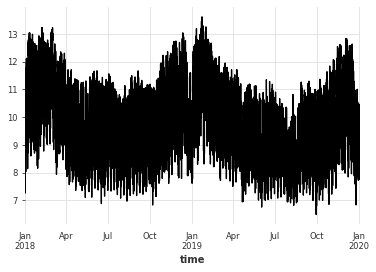

In [15]:
# data = pd.read_parquet('data/Elia/data_load_forecasts.parquet').loc['2019-01-01':'2019-04-25']
data = pd.read_parquet('data/Elia/f4sg.parquet')#.loc['2019-01-01':'2019-04-25']
data = data.reset_index()
# data['time'] = pd.to_datetime(data.time).dt.tz_localize(None)
data['Day_of_week'] = data['time'].dt.dayofweek
data['Hour_of_day'] = data['time'].dt.hour
data = data.set_index('time')
data['Holidays'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('BE').get(x)).values
data['Holidays'] = data['Holidays'].astype('bool').astype('int')
data.columns = ['y','Temperature','Day_of_week','Hour_of_day','Holidays']
data['Smoothed_temperature'] = data.Temperature.rolling(337, center=True).mean()
data.y = data.y/1000
data.y.plot()
data


In [21]:
input_timeseries = TimeSeries.from_dataframe(data, value_cols=['y'])#[0:-24]
# future = TimeSeries.from_dataframe(data, value_cols=['Pressure_kpa', 'Cloud Cover (%)',
#                                                      'Humidity (%)','Temperature (C)', 
#                                                      'Wind Direction (deg)', 'Wind Speed (kmh)'])
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)', 'sin_hour', 'cos_hour'])
input_timeseries

<TimeSeries (DataArray) (time: 17544, component: 1, sample: 1)>
array([[[8.1435    ]],

       [[7.789     ]],

       [[7.47075   ]],

       ...,

       [[9.14866667]],

       [[9.2915    ]],

       [[8.76833333]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-01-01T23:00:00
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [22]:
input_train, input_test = input_timeseries.split_before(pd.to_datetime('2019-01-01'))

In [24]:
# from optuna.integration import PyTorchLightningPruningCallback
# from pytorch_lightning.callbacks import EarlyStopping
# from sklearn.preprocessing import MaxAbsScaler

# from darts.dataprocessing.transformers import Scale
# from darts.datasets import AirPassengersDatasetr
# from darts.metrics import smape
# from darts.models import TCNModel
# from darts.utils.likelihood_models import GaussianLikelihood

# load data
# series = AirPassengersDataset().load().astype(np.float32)

# split in train / validation (note: in practice we would also need a test set)
# VAL_LEN = 36
# train, val = series[:-VAL_LEN], series[-VAL_LEN:]

# scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)


def eval_model(model, past_covariates=None, future_covariates=None, retrain=False):
    
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2019-01-01'), 
#                                           start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)

    error = input_timeseries[-len(backtest):].pd_series() - backtest.pd_series()
    
    return np.mean(np.abs(error))


# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 336)
#     out_len = trial.suggest_int("out_len", 1, in_len-1)

    # Other hyperparameters
#     kernel_size = trial.suggest_int("kernel_size", 2, 5)
#     num_filters = trial.suggest_int("num_filters", 1, 5)
#     weight_norm = trial.suggest_categorical("weight_norm", [False, True])
#     dilation_base = trial.suggest_int("dilation_base", 2, 4)
#     dropout = trial.suggest_float("dropout", 0.0, 0.4)
#     lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
#     include_year = trial.suggest_categorical("year", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
#     pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
#     early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
#     callbacks = [pruner, early_stopper]

    # detect if a GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#         }
#         num_workers = 4
#     else:
#         pl_trainer_kwargs = {"callbacks": callbacks}
#         num_workers = 0

    # optionally also add the (scaled) year value as a past covariate
#     if include_year:
#         encoders = {"datetime_attribute": {"past": ["year"]},
#                     "transformer": Scaler()}
#     else:
#         encoders = None

    # reproducibility
#     torch.manual_seed(42)

    # build the TCN model
#     model = TCNModel(
#         input_chunk_length=in_len,
#         output_chunk_length=out_len,
#         batch_size=32,
#         n_epochs=100,
#         nr_epochs_val_period=1,
#         kernel_size=kernel_size,
#         num_filters=num_filters,
#         weight_norm=weight_norm,
#         dilation_base=dilation_base,
#         dropout=dropout,
#         optimizer_kwargs={"lr": lr},
#         add_encoders=encoders,
#         likelihood=GaussianLikelihood(),
#         pl_trainer_kwargs=pl_trainer_kwargs,
#         model_name="tcn_model",
#         force_reset=True,
#         save_checkpoints=True,
#     )

    model = RegressionModel(lags=list(range(-in_len,0)))

    
    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
#     model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])

    # train the model
#     model.fit(
#         series=train,
#         val_series=model_val_set,
#         num_loader_workers=num_workers,
#     )

    model.fit(input_train)

    # reload best model over course of training
#     model = TCNModel.load_from_checkpoint("tcn_model")

    # Evaluate how good it is on the validation set, using sMAPE
#     preds = model.predict(series=train, n=val_len)
#     smapes = smape(val, preds, n_jobs=-1, verbose=True)
#     smape_val = np.mean(smapes)

#     return smape_val if smape_val != np.nan else float("inf")

    return eval_model(model, retrain=False)


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the sMAPE on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

[I 2022-12-24 16:38:40,776] A new study created in memory with name: no-name-995a49f8-177d-42a1-9db8-1743613944bc


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:39:44,272] Trial 0 finished with value: 0.5263496318902852 and parameters: {'in_len': 119}. Best is trial 0 with value: 0.5263496318902852.


Current value: 0.5263496318902852, Current params: {'in_len': 119}
Best value: 0.5263496318902852, Best params: {'in_len': 119}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:40:51,528] Trial 1 finished with value: 0.3504057922576553 and parameters: {'in_len': 303}. Best is trial 1 with value: 0.3504057922576553.


Current value: 0.3504057922576553, Current params: {'in_len': 303}
Best value: 0.3504057922576553, Best params: {'in_len': 303}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:41:56,207] Trial 2 finished with value: 0.4788826914175695 and parameters: {'in_len': 145}. Best is trial 1 with value: 0.3504057922576553.


Current value: 0.4788826914175695, Current params: {'in_len': 145}
Best value: 0.3504057922576553, Best params: {'in_len': 303}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:43:04,769] Trial 3 finished with value: 0.35101571603648285 and parameters: {'in_len': 300}. Best is trial 1 with value: 0.3504057922576553.


Current value: 0.35101571603648285, Current params: {'in_len': 300}
Best value: 0.3504057922576553, Best params: {'in_len': 303}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:44:09,443] Trial 4 finished with value: 0.5241620674199459 and parameters: {'in_len': 126}. Best is trial 1 with value: 0.3504057922576553.


Current value: 0.5241620674199459, Current params: {'in_len': 126}
Best value: 0.3504057922576553, Best params: {'in_len': 303}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:45:16,326] Trial 5 finished with value: 0.3491383922831136 and parameters: {'in_len': 215}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3491383922831136, Current params: {'in_len': 215}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:46:22,123] Trial 6 finished with value: 0.34969619742243924 and parameters: {'in_len': 195}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.34969619742243924, Current params: {'in_len': 195}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:47:27,731] Trial 7 finished with value: 0.4026837866534354 and parameters: {'in_len': 157}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.4026837866534354, Current params: {'in_len': 157}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:48:37,206] Trial 8 finished with value: 0.3509369835785367 and parameters: {'in_len': 309}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3509369835785367, Current params: {'in_len': 309}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:49:43,312] Trial 9 finished with value: 0.3499339890313693 and parameters: {'in_len': 200}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3499339890313693, Current params: {'in_len': 200}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:50:46,237] Trial 10 finished with value: 0.576543530899142 and parameters: {'in_len': 46}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.576543530899142, Current params: {'in_len': 46}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:51:52,718] Trial 11 finished with value: 0.3496602210536914 and parameters: {'in_len': 227}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3496602210536914, Current params: {'in_len': 227}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:52:58,748] Trial 12 finished with value: 0.35132096885481934 and parameters: {'in_len': 248}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.35132096885481934, Current params: {'in_len': 248}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:54:04,775] Trial 13 finished with value: 0.35054408930535275 and parameters: {'in_len': 238}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.35054408930535275, Current params: {'in_len': 238}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:55:12,820] Trial 14 finished with value: 0.349985012006376 and parameters: {'in_len': 245}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.349985012006376, Current params: {'in_len': 245}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:56:15,813] Trial 15 finished with value: 0.5759623023694558 and parameters: {'in_len': 71}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.5759623023694558, Current params: {'in_len': 71}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:57:21,621] Trial 16 finished with value: 0.35063855879816236 and parameters: {'in_len': 206}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.35063855879816236, Current params: {'in_len': 206}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:58:28,345] Trial 17 finished with value: 0.35355708425914756 and parameters: {'in_len': 269}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.35355708425914756, Current params: {'in_len': 269}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 16:59:31,232] Trial 18 finished with value: 0.567394408924997 and parameters: {'in_len': 94}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.567394408924997, Current params: {'in_len': 94}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:00:39,108] Trial 19 finished with value: 0.3521959733600969 and parameters: {'in_len': 336}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3521959733600969, Current params: {'in_len': 336}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:01:40,674] Trial 20 finished with value: 1.1266697981969414 and parameters: {'in_len': 12}. Best is trial 5 with value: 0.3491383922831136.


Current value: 1.1266697981969414, Current params: {'in_len': 12}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:02:46,428] Trial 21 finished with value: 0.3495164917315833 and parameters: {'in_len': 193}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3495164917315833, Current params: {'in_len': 193}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:03:51,220] Trial 22 finished with value: 0.3514198879933579 and parameters: {'in_len': 176}. Best is trial 5 with value: 0.3491383922831136.


Current value: 0.3514198879933579, Current params: {'in_len': 176}
Best value: 0.3491383922831136, Best params: {'in_len': 215}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:04:57,877] Trial 23 finished with value: 0.3488042446147211 and parameters: {'in_len': 221}. Best is trial 23 with value: 0.3488042446147211.


Current value: 0.3488042446147211, Current params: {'in_len': 221}
Best value: 0.3488042446147211, Best params: {'in_len': 221}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:06:03,186] Trial 24 finished with value: 0.35057500328827634 and parameters: {'in_len': 178}. Best is trial 23 with value: 0.3488042446147211.


Current value: 0.35057500328827634, Current params: {'in_len': 178}
Best value: 0.3488042446147211, Best params: {'in_len': 221}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:07:11,328] Trial 25 finished with value: 0.353205416076511 and parameters: {'in_len': 271}. Best is trial 23 with value: 0.3488042446147211.


Current value: 0.353205416076511, Current params: {'in_len': 271}
Best value: 0.3488042446147211, Best params: {'in_len': 221}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:08:17,907] Trial 26 finished with value: 0.3492382695872089 and parameters: {'in_len': 212}. Best is trial 23 with value: 0.3488042446147211.


Current value: 0.3492382695872089, Current params: {'in_len': 212}
Best value: 0.3488042446147211, Best params: {'in_len': 221}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:09:23,835] Trial 27 finished with value: 0.34873090647504895 and parameters: {'in_len': 217}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.34873090647504895, Current params: {'in_len': 217}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:10:32,078] Trial 28 finished with value: 0.3533287236419124 and parameters: {'in_len': 272}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.3533287236419124, Current params: {'in_len': 272}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:11:37,545] Trial 29 finished with value: 0.4421110763095259 and parameters: {'in_len': 151}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.4421110763095259, Current params: {'in_len': 151}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:12:48,087] Trial 30 finished with value: 0.34873090647504895 and parameters: {'in_len': 217}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.34873090647504895, Current params: {'in_len': 217}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:13:54,129] Trial 31 finished with value: 0.3496602210536914 and parameters: {'in_len': 227}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.3496602210536914, Current params: {'in_len': 227}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:15:00,883] Trial 32 finished with value: 0.35294258032291764 and parameters: {'in_len': 259}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.35294258032291764, Current params: {'in_len': 259}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:16:06,647] Trial 33 finished with value: 0.3491961207145458 and parameters: {'in_len': 226}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.3491961207145458, Current params: {'in_len': 226}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:17:14,529] Trial 34 finished with value: 0.35270687415745167 and parameters: {'in_len': 289}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.35270687415745167, Current params: {'in_len': 289}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:18:19,853] Trial 35 finished with value: 0.3576244825483585 and parameters: {'in_len': 173}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.3576244825483585, Current params: {'in_len': 173}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:19:24,182] Trial 36 finished with value: 0.5028230073947835 and parameters: {'in_len': 129}. Best is trial 27 with value: 0.34873090647504895.


Current value: 0.5028230073947835, Current params: {'in_len': 129}
Best value: 0.34873090647504895, Best params: {'in_len': 217}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:20:30,536] Trial 37 finished with value: 0.348729571071885 and parameters: {'in_len': 219}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.348729571071885, Current params: {'in_len': 219}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:21:35,678] Trial 38 finished with value: 0.34939057231903164 and parameters: {'in_len': 192}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.34939057231903164, Current params: {'in_len': 192}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:22:40,662] Trial 39 finished with value: 0.4005061694915704 and parameters: {'in_len': 164}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.4005061694915704, Current params: {'in_len': 164}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:23:44,980] Trial 40 finished with value: 0.4581762781330291 and parameters: {'in_len': 138}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.4581762781330291, Current params: {'in_len': 138}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:24:51,008] Trial 41 finished with value: 0.3490134600540266 and parameters: {'in_len': 216}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3490134600540266, Current params: {'in_len': 216}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:25:56,597] Trial 42 finished with value: 0.3489004116337671 and parameters: {'in_len': 214}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3489004116337671, Current params: {'in_len': 214}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:27:04,089] Trial 43 finished with value: 0.349377977677919 and parameters: {'in_len': 240}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.349377977677919, Current params: {'in_len': 240}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:28:10,272] Trial 44 finished with value: 0.3488726043151634 and parameters: {'in_len': 187}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3488726043151634, Current params: {'in_len': 187}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:29:16,481] Trial 45 finished with value: 0.3491880234263785 and parameters: {'in_len': 181}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3491880234263785, Current params: {'in_len': 181}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:30:22,257] Trial 46 finished with value: 0.35263132399078956 and parameters: {'in_len': 254}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35263132399078956, Current params: {'in_len': 254}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:31:25,443] Trial 47 finished with value: 0.541233583220614 and parameters: {'in_len': 114}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.541233583220614, Current params: {'in_len': 114}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:32:31,799] Trial 48 finished with value: 0.35018280889154974 and parameters: {'in_len': 232}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35018280889154974, Current params: {'in_len': 232}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:33:38,919] Trial 49 finished with value: 0.34899705424778255 and parameters: {'in_len': 199}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.34899705424778255, Current params: {'in_len': 199}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:34:46,697] Trial 50 finished with value: 0.353051314798362 and parameters: {'in_len': 290}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.353051314798362, Current params: {'in_len': 290}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:35:52,563] Trial 51 finished with value: 0.348729571071885 and parameters: {'in_len': 219}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.348729571071885, Current params: {'in_len': 219}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:36:58,620] Trial 52 finished with value: 0.3487461969157822 and parameters: {'in_len': 220}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3487461969157822, Current params: {'in_len': 220}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:38:04,127] Trial 53 finished with value: 0.3487461969157822 and parameters: {'in_len': 220}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3487461969157822, Current params: {'in_len': 220}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:39:09,856] Trial 54 finished with value: 0.35090577083760327 and parameters: {'in_len': 205}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35090577083760327, Current params: {'in_len': 205}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:40:16,632] Trial 55 finished with value: 0.35066911607882567 and parameters: {'in_len': 237}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35066911607882567, Current params: {'in_len': 237}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:41:23,169] Trial 56 finished with value: 0.35256627328847756 and parameters: {'in_len': 253}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35256627328847756, Current params: {'in_len': 253}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:42:28,998] Trial 57 finished with value: 0.4052978882646859 and parameters: {'in_len': 165}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.4052978882646859, Current params: {'in_len': 165}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:43:36,415] Trial 58 finished with value: 0.35325114900139765 and parameters: {'in_len': 262}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35325114900139765, Current params: {'in_len': 262}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:44:43,024] Trial 59 finished with value: 0.35096628868036867 and parameters: {'in_len': 207}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35096628868036867, Current params: {'in_len': 207}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:45:50,692] Trial 60 finished with value: 0.3541795346988703 and parameters: {'in_len': 282}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3541795346988703, Current params: {'in_len': 282}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:46:56,412] Trial 61 finished with value: 0.34920542538372124 and parameters: {'in_len': 223}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.34920542538372124, Current params: {'in_len': 223}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:48:04,126] Trial 62 finished with value: 0.35055669524777755 and parameters: {'in_len': 243}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35055669524777755, Current params: {'in_len': 243}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:49:09,531] Trial 63 finished with value: 0.3490570845644504 and parameters: {'in_len': 218}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3490570845644504, Current params: {'in_len': 218}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:50:15,535] Trial 64 finished with value: 0.34899705424778255 and parameters: {'in_len': 199}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.34899705424778255, Current params: {'in_len': 199}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:51:21,367] Trial 65 finished with value: 0.3505818812354803 and parameters: {'in_len': 234}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.3505818812354803, Current params: {'in_len': 234}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:52:26,455] Trial 66 finished with value: 0.35026604154755325 and parameters: {'in_len': 190}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35026604154755325, Current params: {'in_len': 190}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:53:34,280] Trial 67 finished with value: 0.35240317337331106 and parameters: {'in_len': 249}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35240317337331106, Current params: {'in_len': 249}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:54:40,847] Trial 68 finished with value: 0.34889956517534165 and parameters: {'in_len': 224}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.34889956517534165, Current params: {'in_len': 224}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:55:46,531] Trial 69 finished with value: 0.35088242481371534 and parameters: {'in_len': 209}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35088242481371534, Current params: {'in_len': 209}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:56:53,544] Trial 70 finished with value: 0.35359721955352164 and parameters: {'in_len': 264}. Best is trial 37 with value: 0.348729571071885.


Current value: 0.35359721955352164, Current params: {'in_len': 264}
Best value: 0.348729571071885, Best params: {'in_len': 219}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:57:59,193] Trial 71 finished with value: 0.3487147929781023 and parameters: {'in_len': 186}. Best is trial 71 with value: 0.3487147929781023.


Current value: 0.3487147929781023, Current params: {'in_len': 186}
Best value: 0.3487147929781023, Best params: {'in_len': 186}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 17:59:05,247] Trial 72 finished with value: 0.3490570845644504 and parameters: {'in_len': 218}. Best is trial 71 with value: 0.3487147929781023.


Current value: 0.3490570845644504, Current params: {'in_len': 218}
Best value: 0.3487147929781023, Best params: {'in_len': 186}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:00:11,937] Trial 73 finished with value: 0.3486094128670294 and parameters: {'in_len': 185}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3486094128670294, Current params: {'in_len': 185}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:01:17,608] Trial 74 finished with value: 0.34864502810623127 and parameters: {'in_len': 184}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.34864502810623127, Current params: {'in_len': 184}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:02:24,819] Trial 75 finished with value: 0.4107312185591766 and parameters: {'in_len': 166}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.4107312185591766, Current params: {'in_len': 166}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:03:29,501] Trial 76 finished with value: 0.4421110763095259 and parameters: {'in_len': 151}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.4421110763095259, Current params: {'in_len': 151}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:04:34,739] Trial 77 finished with value: 0.34864502810623127 and parameters: {'in_len': 184}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.34864502810623127, Current params: {'in_len': 184}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:05:38,566] Trial 78 finished with value: 0.3514198879933579 and parameters: {'in_len': 176}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3514198879933579, Current params: {'in_len': 176}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:06:42,666] Trial 79 finished with value: 0.3491880234263785 and parameters: {'in_len': 181}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3491880234263785, Current params: {'in_len': 181}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:07:46,626] Trial 80 finished with value: 0.40632760445410787 and parameters: {'in_len': 156}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.40632760445410787, Current params: {'in_len': 156}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:08:51,678] Trial 81 finished with value: 0.3486094128670294 and parameters: {'in_len': 185}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3486094128670294, Current params: {'in_len': 185}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:09:56,779] Trial 82 finished with value: 0.34969619742243924 and parameters: {'in_len': 195}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.34969619742243924, Current params: {'in_len': 195}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:11:01,627] Trial 83 finished with value: 0.3487147929781023 and parameters: {'in_len': 186}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3487147929781023, Current params: {'in_len': 186}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:12:05,519] Trial 84 finished with value: 0.4581762781330291 and parameters: {'in_len': 138}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.4581762781330291, Current params: {'in_len': 138}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:13:10,171] Trial 85 finished with value: 0.3486094128670294 and parameters: {'in_len': 185}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3486094128670294, Current params: {'in_len': 185}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:14:15,085] Trial 86 finished with value: 0.3488726043151634 and parameters: {'in_len': 187}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3488726043151634, Current params: {'in_len': 187}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:15:19,545] Trial 87 finished with value: 0.3573767045768815 and parameters: {'in_len': 170}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3573767045768815, Current params: {'in_len': 170}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:16:23,228] Trial 88 finished with value: 0.41258733423202226 and parameters: {'in_len': 155}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.41258733423202226, Current params: {'in_len': 155}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:17:27,049] Trial 89 finished with value: 0.3486094128670294 and parameters: {'in_len': 185}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3486094128670294, Current params: {'in_len': 185}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:18:30,727] Trial 90 finished with value: 0.34864502810623127 and parameters: {'in_len': 184}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.34864502810623127, Current params: {'in_len': 184}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:19:34,957] Trial 91 finished with value: 0.34890009918413967 and parameters: {'in_len': 182}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.34890009918413967, Current params: {'in_len': 182}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:20:38,619] Trial 92 finished with value: 0.3971746540136213 and parameters: {'in_len': 161}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3971746540136213, Current params: {'in_len': 161}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:21:42,957] Trial 93 finished with value: 0.3499339890313693 and parameters: {'in_len': 200}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3499339890313693, Current params: {'in_len': 200}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:22:46,262] Trial 94 finished with value: 0.4519626751700439 and parameters: {'in_len': 144}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.4519626751700439, Current params: {'in_len': 144}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:23:49,904] Trial 95 finished with value: 0.3573767045768815 and parameters: {'in_len': 170}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3573767045768815, Current params: {'in_len': 170}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:24:54,949] Trial 96 finished with value: 0.3488726043151634 and parameters: {'in_len': 187}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3488726043151634, Current params: {'in_len': 187}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:25:59,565] Trial 97 finished with value: 0.35110807738446087 and parameters: {'in_len': 204}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.35110807738446087, Current params: {'in_len': 204}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:27:06,512] Trial 98 finished with value: 0.3514198879933579 and parameters: {'in_len': 176}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3514198879933579, Current params: {'in_len': 176}
Best value: 0.3486094128670294, Best params: {'in_len': 185}


  0%|          | 0/8761 [00:00<?, ?it/s]

[I 2022-12-24 18:28:10,720] Trial 99 finished with value: 0.3497684520122363 and parameters: {'in_len': 189}. Best is trial 73 with value: 0.3486094128670294.


Current value: 0.3497684520122363, Current params: {'in_len': 189}
Best value: 0.3486094128670294, Best params: {'in_len': 185}
